In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataTrans').getOrCreate()

In [2]:
traintest = spark.read.csv("traintest.csv", header=True, inferSchema=True)


In [3]:
traintest = traintest.withColumn('Density', traintest['POP']/traintest['AREA'])
traintest.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- STATENAME: string (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- SEASON: string (nullable = true)
 |-- POP: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- HealthCare_All: double (nullable = true)
 |-- HealthCare_Under65: double (nullable = true)
 |-- HealthCare_Under18: double (nullable = true)
 |-- HealthCare_Over65: double (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- TypeB: integer (nullable = true)
 |-- PrevWeek: string (nullable = true)
 |-- NSporadic: integer (nullable = true)
 |-- NLocalAct: integer (nullable = true)
 |-- NNoAct: integer (nullable = true)
 |-- NRegional: integer (n

In [4]:
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
from pyspark.ml import Pipeline


State_indexer = StringIndexer(inputCol='STATENAME',outputCol='StateIndex')
State_encoder = OneHotEncoder(inputCol='StateIndex',outputCol='StateVec')

Activity_indexer = StringIndexer(inputCol='ACTIVITYESTIMATE',outputCol='ActivityIndex')
Activity_encoder = OneHotEncoder(inputCol='ActivityIndex',outputCol='ActivityVec')

Season_indexer = StringIndexer(inputCol='SEASON',outputCol='SeasonIndex')
Season_encoder = OneHotEncoder(inputCol='SeasonIndex',outputCol='SeasonVec')

PrevWeek_indexer = StringIndexer(inputCol='PrevWeek',outputCol='PrevWeekIndex')
PrevWeek_encoder = OneHotEncoder(inputCol='PrevWeekIndex',outputCol='PrevWeekVec')


assembler = VectorAssembler(
  inputCols=['StateVec',
             'ActivityVec',
             'WEEK',
             'SeasonVec',
             'POP',
             'AREA',
             'HealthCare_All',
             'HealthCare_Under65',
             'HealthCare_Under18',
             'HealthCare_Over65',
             'INCOME',
             'TypeA_subH3',
             'TypeA_subH1N1',
             'TypeA',
             'TypeA_subH3N2',
             'TypeA_subU',
             'TypeA_subH1',
             'TypeB',
             'PrevWeekVec',
             'NSporadic',
             'NLocalAct',
             'NNoAct',
             'NRegional',
             'NWidespread',
             'Density'],
    outputCol="features")

pipeline = Pipeline(stages=[State_indexer,Activity_indexer,Season_indexer,PrevWeek_indexer])

tt = pipeline.fit(traintest).transform(traintest)


col_names = ['ActivityIndex', 'StateIndex', 'WEEK', 'SeasonIndex', 'POP', 'AREA', 'HealthCare_All', 'HealthCare_Under65', 'HealthCare_Under18', 'HealthCare_Over65', 'INCOME', 'TypeA_subH3', 'TypeA_subH1N1', 'TypeA', 'TypeA_subH3N2', 'TypeA_subU', 'TypeA_subH1', 'TypeB', 'PrevWeekIndex', 'NSporadic', 'NLocalAct', 'NNoAct', 'NRegional', 'NWidespread','Density']
tt = tt.select(col_names)
features = tt.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,ActivityIndex,StateIndex,WEEK,SeasonIndex,POP,AREA,HealthCare_All,HealthCare_Under65,HealthCare_Under18,HealthCare_Over65,...,TypeA_subU,TypeA_subH1,TypeB,PrevWeekIndex,NSporadic,NLocalAct,NNoAct,NRegional,NWidespread,Density
ActivityIndex,1.000000,0.022511,-0.031001,-0.008531,-0.064427,-0.033646,-0.018723,-0.018819,-0.039936,-0.008513,...,0.027068,-0.006063,0.027199,0.664035,-0.183003,0.025258,0.017566,0.196836,0.050934,-0.010900
StateIndex,0.022511,1.000000,-0.000909,-0.000043,-0.305515,-0.281786,0.169732,0.170637,-0.038197,0.171002,...,0.000550,0.000477,0.001266,0.029562,-0.003654,-0.000127,-0.002975,0.001282,0.001666,0.247325
WEEK,-0.031001,-0.000909,1.000000,-0.005160,0.000708,0.000307,-0.000461,-0.000518,-0.000289,0.000065,...,0.220956,0.158300,-0.266208,-0.026160,0.363888,-0.023752,0.381741,-0.222313,-0.409310,0.000562
SeasonIndex,-0.008531,-0.000043,-0.005160,1.000000,-0.004446,0.000266,-0.001180,-0.001210,-0.001109,0.000488,...,0.166621,0.139328,0.089701,-0.011569,-0.208958,-0.345358,-0.026664,-0.296561,-0.153407,-0.003796
POP,-0.064427,-0.305515,0.000708,-0.004446,1.000000,0.143579,-0.067589,-0.076903,0.079177,-0.125418,...,-0.005327,-0.004462,0.007865,-0.067044,0.001985,0.001262,-0.001109,0.000308,0.000904,-0.052490
AREA,-0.033646,-0.281786,0.000307,0.000266,0.143579,1.000000,-0.038899,-0.037718,-0.006687,0.044065,...,-0.000181,-0.000149,-0.000393,-0.040174,0.000866,0.000120,0.000756,-0.000360,-0.000500,-0.202877
HealthCare_All,-0.018723,0.169732,-0.000461,-0.001180,-0.067589,-0.038899,1.000000,0.996759,0.855081,0.538449,...,0.000131,0.000129,0.000363,-0.015224,-0.000340,0.000718,-0.000952,0.000542,0.000410,0.113061
HealthCare_Under65,-0.018819,0.170637,-0.000518,-0.001210,-0.076903,-0.037718,0.996759,1.000000,0.850746,0.497136,...,0.000128,0.000126,0.000355,-0.015670,-0.000354,0.000809,-0.000979,0.000578,0.000407,0.102576
HealthCare_Under18,-0.039936,-0.038197,-0.000289,-0.001109,0.079177,-0.006687,0.855081,0.850746,1.000000,0.444257,...,-0.000061,-0.000035,-0.000068,-0.037150,0.001062,0.000467,0.000326,-0.000078,-0.000270,-0.008936
HealthCare_Over65,-0.008513,0.171002,0.000065,0.000488,-0.125418,0.044065,0.538449,0.497136,0.444257,1.000000,...,0.000031,0.000039,0.000106,-0.003167,-0.000598,-0.000094,-0.000604,0.000099,0.000174,0.016141


In [5]:
import numpy as np 
import matplotlib 
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8), dpi=160, facecolor='w', edgecolor='k')

col = ['Activity', 'State', 'WEEK', 'Season', 'POP', 'AREA', 'HealthCare_All', 'HealthCare_Under65', 'HealthCare_Under18', 'HealthCare_Over65', 'INCOME', 'TypeA_subH3', 'TypeA_subH1N1', 'TypeA', 'TypeA_subH3N2', 'TypeA_subU', 'TypeA_subH1', 'TypeB', 'PrevWeek', 'NSporadic', 'NLocalAct', 'NNoAct', 'NRegional', 'NWidespread']

matplotlib.pyplot.imshow(corr_df)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.xticks(range(len(corr_df)),col, rotation=90)
matplotlib.pyplot.yticks(range(len(corr_df)),col)
matplotlib.pyplot.show()

corr_df.style.background_gradient(cmap='Blues')

<Figure size 1280x1280 with 2 Axes>

,ActivityIndex,StateIndex,WEEK,SeasonIndex,POP,AREA,HealthCare_All,HealthCare_Under65,HealthCare_Under18,HealthCare_Over65,INCOME,TypeA_subH3,TypeA_subH1N1,TypeA,TypeA_subH3N2,TypeA_subU,TypeA_subH1,TypeB,PrevWeekIndex,NSporadic,NLocalAct,NNoAct,NRegional,NWidespread,Density
ActivityIndex,1,0.0225105,-0.0310007,-0.00853068,-0.0644269,-0.0336457,-0.0187235,-0.0188191,-0.039936,-0.00851309,-0.0438109,0.00692646,0.0549115,0.0450702,-0.0142177,0.0270676,-0.00606268,0.0271994,0.664035,-0.183003,0.0252585,0.0175664,0.196836,0.0509341,-0.0108999
StateIndex,0.0225105,1,-0.000909475,-4.28981e-05,-0.305515,-0.281786,0.169732,0.170637,-0.0381972,0.171002,0.132723,0.0007158,0.00114419,0.000768871,-0.00113572,0.000549517,0.00047749,0.00126591,0.0295617,-0.00365354,-0.000127388,-0.00297538,0.00128237,0.00166556,0.247325
WEEK,-0.0310007,-0.000909475,1,-0.00515982,0.000707738,0.000306697,-0.00046077,-0.00051849,-0.000289159,6.51736e-05,0.000675246,-0.118622,0.0508017,0.0855141,0.107459,0.220956,0.1583,-0.266208,-0.0261605,0.363888,-0.0237521,0.381741,-0.222313,-0.40931,0.000561596
SeasonIndex,-0.00853068,-4.28981e-05,-0.00515982,1,-0.00444605,0.000266439,-0.00118006,-0.00120976,-0.00110914,0.000487862,-0.0584526,0.0838963,-0.0342987,0.129461,0.0631932,0.166621,0.139328,0.089701,-0.0115688,-0.208958,-0.345358,-0.0266643,-0.296561,-0.153407,-0.00379643
POP,-0.0644269,-0.305515,0.000707738,-0.00444605,1,0.143579,-0.0675889,-0.0769027,0.0791774,-0.125418,0.00731367,0.00299844,-0.00488777,-0.00430287,0.000692737,-0.00532665,-0.00446216,0.00786497,-0.0670439,0.00198484,0.00126241,-0.0011087,0.000308243,0.000904082,-0.0524899
AREA,-0.0336457,-0.281786,0.000306697,0.000266439,0.143579,1,-0.0388992,-0.037718,-0.00668729,0.0440648,0.0962362,-0.000144002,-0.000350417,-0.000227018,0.000422991,-0.000180704,-0.000148907,-0.000393268,-0.040174,0.000866126,0.000119505,0.000755877,-0.000360241,-0.000500286,-0.202877
HealthCare_All,-0.0187235,0.169732,-0.00046077,-0.00118006,-0.0675889,-0.0388992,1,0.996759,0.855081,0.538449,-0.0993784,-0.000258752,0.000359036,0.000261362,-8.845e-05,0.000130822,0.000128523,0.000362784,-0.0152242,-0.000339671,0.00071849,-0.000952227,0.000541558,0.00041028,0.113061
HealthCare_Under65,-0.0188191,0.170637,-0.00051849,-0.00120976,-0.0769027,-0.037718,0.996759,1,0.850746,0.497136,-0.0919456,-0.000287033,0.000359282,0.000253146,-9.51225e-05,0.000127853,0.000125638,0.000354988,-0.0156701,-0.000353898,0.000809262,-0.000978506,0.000578137,0.000407009,0.102576
HealthCare_Under18,-0.039936,-0.0381972,-0.000289159,-0.00110914,0.0791774,-0.00668729,0.855081,0.850746,1,0.444257,-0.0791151,-0.000698427,-4.51337e-05,-5.32539e-05,0.000334835,-6.09307e-05,-3.47409e-05,-6.83695e-05,-0.0371499,0.00106197,0.000466624,0.000325576,-7.849e-05,-0.000270269,-0.00893643
HealthCare_Over65,-0.00851309,0.171002,6.51736e-05,0.000487862,-0.125418,0.0440648,0.538449,0.497136,0.444257,1,-0.00498207,0.000277282,8.55507e-05,0.000107856,-0.000486662,3.0739e-05,3.91354e-05,0.000106256,-0.00316652,-0.000598118,-9.40009e-05,-0.000604385,9.86097e-05,0.000174148,0.0161407


In [4]:
traintest = traintest.select('ACTIVITYESTIMATE', 'WEEK', 'POP', 'AREA', 'HealthCare_All', 'HealthCare_Over65', 'INCOME', 'TypeA_subH3', 'TypeA_subH1N1', 'TypeA', 'TypeA_subH3N2', 'TypeA_subU', 'TypeA_subH1', 'PrevWeek', 'NSporadic', 'NLocalAct', 'NNoAct', 'NRegional', 'NWidespread','Density')

traintest.toPandas().head(5)

,ACTIVITYESTIMATE,WEEK,POP,AREA,HealthCare_All,HealthCare_Over65,INCOME,TypeA_subH3,TypeA_subH1N1,TypeA,TypeA_subH3N2,TypeA_subU,TypeA_subH1,PrevWeek,NSporadic,NLocalAct,NNoAct,NRegional,NWidespread,Density
0,Widespread,41,4757938,135767,84.599998,98.5,39980,5,1877,34,0,8,4,Widespread,0,2,0,8,41,35.044878
1,Widespread,42,4757938,135767,84.599998,98.5,39980,1,2216,57,0,9,3,Widespread,0,2,0,3,46,35.044878
2,Widespread,43,4757938,135767,84.599998,98.5,39980,6,2387,57,0,24,2,Widespread,0,1,0,2,48,35.044878
3,Widespread,44,4757938,135767,84.599998,98.5,39980,4,3210,79,0,24,8,Widespread,0,1,0,2,48,35.044878
4,Widespread,45,4757938,135767,84.599998,98.5,39980,2,5108,160,0,18,1,Widespread,0,1,0,4,46,35.044878


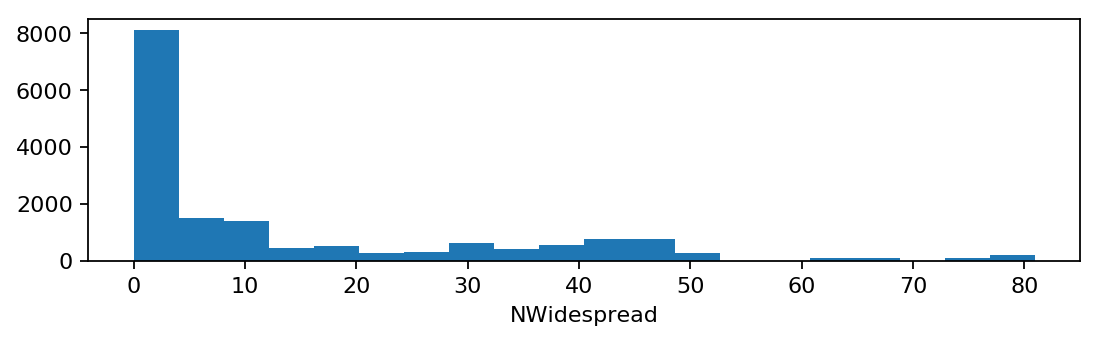

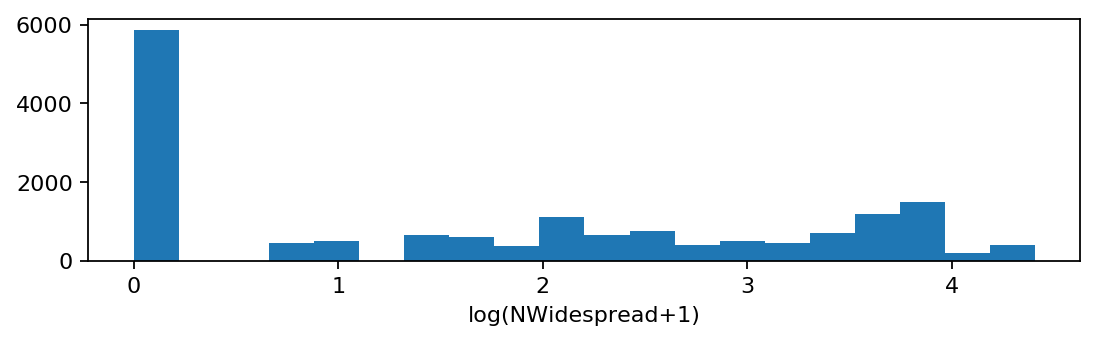

In [21]:
import matplotlib.pyplot as plt
figure(num=None, figsize=(8, 2), dpi=160, facecolor='w', edgecolor='k')
plt.hist(traintest.toPandas()['NWidespread'],bins = 20)
plt.xlabel('NWidespread')
plt.show()
figure(num=None, figsize=(8, 2), dpi=160, facecolor='w', edgecolor='k')
plt.hist(np.log(traintest.toPandas()['NWidespread']+1),bins = 20)
plt.xlabel('log(NWidespread+1)')
plt.show()

In [5]:
import numpy as np


traintest = traintest.toPandas()

traintest['NWidespread'] = np.log(traintest['NWidespread']+1)
traintest.head(5)

,ACTIVITYESTIMATE,WEEK,POP,AREA,HealthCare_All,HealthCare_Over65,INCOME,TypeA_subH3,TypeA_subH1N1,TypeA,TypeA_subH3N2,TypeA_subU,TypeA_subH1,PrevWeek,NSporadic,NLocalAct,NNoAct,NRegional,NWidespread,Density
0,Widespread,41,4757938,135767,84.599998,98.5,39980,5,1877,34,0,8,4,Widespread,0,2,0,8,3.737670,35.044878
1,Widespread,42,4757938,135767,84.599998,98.5,39980,1,2216,57,0,9,3,Widespread,0,2,0,3,3.850148,35.044878
2,Widespread,43,4757938,135767,84.599998,98.5,39980,6,2387,57,0,24,2,Widespread,0,1,0,2,3.891820,35.044878
3,Widespread,44,4757938,135767,84.599998,98.5,39980,4,3210,79,0,24,8,Widespread,0,1,0,2,3.891820,35.044878
4,Widespread,45,4757938,135767,84.599998,98.5,39980,2,5108,160,0,18,1,Widespread,0,1,0,4,3.850148,35.044878


In [6]:
traintest.to_csv('traintest2.csv')